# Content


1. [Motivation](#mot)
2. [Basic Stats](#basic)
   * [Traffic count data](#basic1)
   * [Traffic noise data](#basic2)
   * [Traffic accident data](#basic3)
   * [Air pollution data](#basic4)
   * [Car types data](#basic5)
   * [District data](#basic6)
   * [ Bicycle lanes, parks, trees](#basic7)
3. [Data Analysis](#ana)
   * [How is the distribution of road users in Copenhagen?](#ana1)
   * [How is the distribution of car types according to district?](#ana_ty)
   * [How safe is the traffic in Copenhagen? ](#ana2)
   * [How to plan a safe and green bike trip?](#ana3)
4. [Genre](#genre)
5. [Visualization](#viz)
6. [Discussion](#dis)
7. [Contributions](#cont)

____

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import GeoJson
from folium.plugins import MousePosition, MeasureControl, Fullscreen, LocateControl, Search, TimeSliderChoropleth, TimestampedGeoJson
import geojson
from numpy import nan
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString
from plotly.offline import plot
import plotly
plotly.offline.init_notebook_mode(connected=True) 
colors = ['#636efa', '#EF553B', '#00cc96', '#ab63fa', '#FFA15A', '#19d3f3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

<a id="mot"></a> <br>
# Motivation


Inspired by the blog *I Quant NY*, we decided to make a blog post about our hometown, Copenhagen, called *We Quant CPH*. Copenhagen is internationally known as a very livable city with many cyclists, so we thought it would be interesting to study traffic data. Initially, we focused on the traffic count data, which is a dataset containing counts for cyclists, vehicles, and other road users at various locations in Copenhagen. However, upon further examination of the data structure, we discovered that it was not possible to analyze the temporal changes in traffic patterns due to the way the data were recorded. We were surprised to find that most of the counting spots were dominated by cars, prompting us to expand our analysis to investigate the distribution of cars and the consequences of car traffic in the city. To do this, we utilized datasets on road noise, air pollution, and traffic accidents.

The ultimate goal of the user experience is to engage users in our visualizations and provide them with informative insights. For this reason, we have placed a strong emphasis on interactivity and added filtering options, allowing users to zoom in on their own districts. Additionally, we aim to inform users about the negative consequences of car traffic in cities and motivate them to choose biking as an alternative.


<a id="basic"></a> <br>
# Basic Stats

Due to the amount of datasets, we have chosen to structure this section according to each dataset. The basicstets can be found indivudally to each plot.

<a id="basic1"></a> <br>
### Traffic count data

The traffic count data is available on [Open Data DK's web page](https://www.opendata.dk/city-of-copenhagen/trafiktal). 
The data set contains the calculated Annual Average Daily Traffic (AADT) for vehicles, bicycles and other road users. The chunk below reads the data, and adds columns with longitude and latitudes, respectively.

In [2]:
# Read data
trafic_counts = pd.read_csv('trafiktaelling.csv',  na_values=['nan'])

# Fix coordinates
def extract_coordinates(point_string):
    # Extract x and y coordinates from point string using regular expressions
    pattern = r'POINT \((?P<x>[-+]?[0-9]*\.?[0-9]+) (?P<y>[-+]?[0-9]*\.?[0-9]+)\)'
    match = re.search(pattern, point_string)
    
    # Convert x and y coordinates to floats and return as tuple
    x = float(match.group('x'))
    y = float(match.group('y'))
    return x, y

N = trafic_counts.shape[0]

trafic_counts['X'] = np.zeros(N)
trafic_counts['Y'] = np.zeros(N)

for i in range(N):
    try:
        x, y = extract_coordinates(trafic_counts.iloc[i,:]['wkb_geometry'])
        trafic_counts.loc[i, 'Y']  = x
        trafic_counts.loc[i, 'X']  = y
    except TypeError:
        print(' ')

The data set have the follwing dimension and number of features:

In [3]:
print('Dimension of data set: \t', trafic_counts.shape)
print('\nFeatures: \t', set(trafic_counts.columns))

Dimension of data set: 	 (1108, 39)

Features: 	 {'hvdt_cykler', 'ktj_7_19', 'elloebehjul_pct', 'link', 'taelle_dato', 'hvdt_fod_7_19', 'X', 'vejnavn', 'elloebehjul_7_19', 'lastbiler_7_19', 'aadt_koretojer', 'type', 'aar', 'wkb_geometry', 'Y', 'fod_7_19', 'tung_pct', 'ogc_fid', 'cykler_7_19', 'andre_busser_7_19', 'beskrivelse', 'FID', 'taelling_type', 'aadt_fod_7_21', 'ladcykler_pct_real', 'fod_7_21', 'tung_pct_real', 'fod_7_24', 'aadt_cykler', 'hvdt_fod_7_24', 'hvdt_fod_7_21', 'lastbiler_pct', 'husnummer', 't_nr', 'aadt_fod_label', 'hvdt_koretojer', 'aadt_fod_7_24', 'aadt_fod_7_19', 'ladcykler_pct'}


The plot below shows how the data is distributed in time and for different road users. The data are gathered consistently from 2009 until 2022, with exception of 2020 where the data was not gathered due to the pandemic. The third plot shows that most of the counts are in the category "Other counts". These counts are counts that are not repeated regularly as the other traffic counts. 

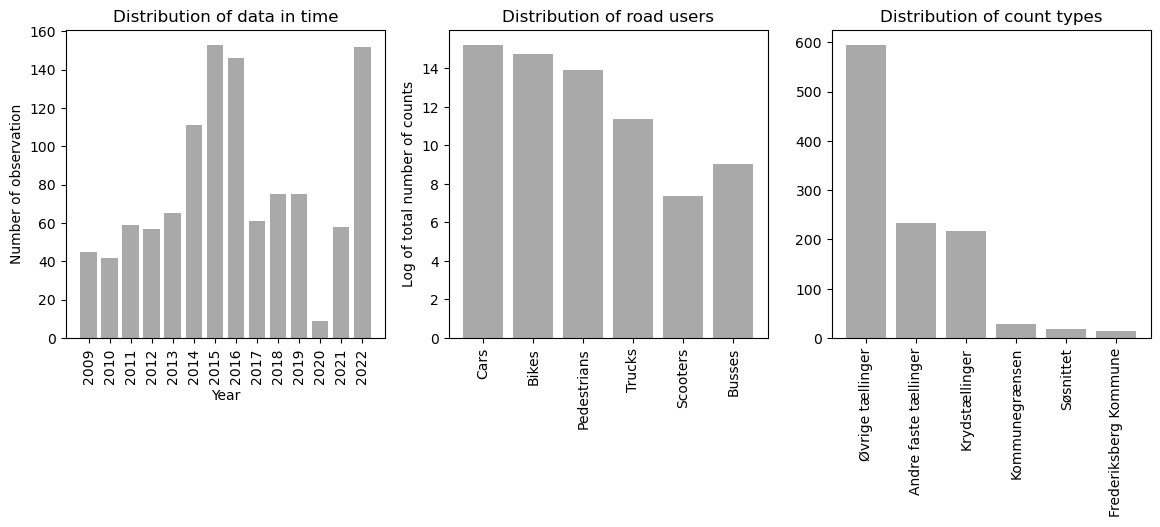

<Figure size 640x480 with 0 Axes>

In [4]:
plt.figure(figsize=(14, 4))
number_of_counts = trafic_counts['aar'].value_counts()

# Plot distribution over time
years = []
for year in range(number_of_counts.index.min(), number_of_counts.index.max()+1):
    years.append(year)

plt.subplot(1, 3, 1)
plt.ylabel('Number of observation')
plt.xlabel('Year')
plt.title('Distribution of data in time')
plt.bar(years, number_of_counts.reindex(years), color = "darkgrey")
plt.xticks(years,rotation=90)

trafic_modes = ['ktj_7_19', 'cykler_7_19', 'fod_7_19', 'lastbiler_7_19', 'elloebehjul_7_19','andre_busser_7_19']

sum_modes = np.zeros(len(trafic_modes))
for i in range(len(trafic_modes)):
    sum_modes[i] = np.nansum(trafic_counts[trafic_modes[i]])

# Plot distribution of road users in log scale    
plt.subplot(1, 3, 2)    
plt.bar(['Cars', 'Bikes', 'Pedestrians', 'Trucks', 'Scooters', 'Busses'], np.log(sum_modes), color='darkgrey')
plt.xticks(rotation=90)
plt.ylabel('Log of total number of counts')
plt.title('Distribution of road users')

# Plot distribution of count types
plt.subplot(1, 3, 3) 
number_of_counts = trafic_counts['taelling_type'].value_counts()
types = number_of_counts.index
plt.bar(types, number_of_counts, color = "darkgrey")
plt.xticks(rotation=90)
plt.title('Distribution of count types')
plt.show()

plt.tight_layout()
plt.show()

If we take a closer look into the recurrent traffic counts, most of the counts are done recently. This means that the historic traffic counts are not in the data, but only the most recent counts. The historic data is unfortunately only available in the period from 2005 to 2014 ([link to data](https://www.opendata.dk/city-of-copenhagen/faste-trafiktaellinger)). We find it most exiting to work with contemporary data, so we chose to stick with this data.

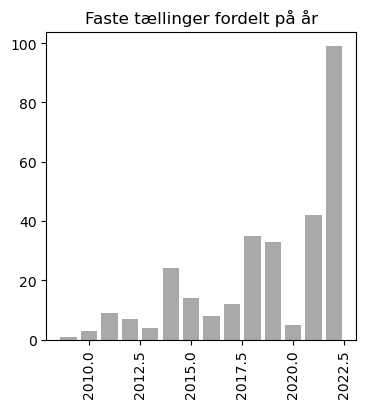

In [5]:
fig = plt.figure(figsize=(4, 4))

types = types[[1,3,4,5]]
number_of_counts = (trafic_counts[trafic_counts['taelling_type'].isin(types)]['aar']).value_counts()
plt.bar(number_of_counts.sort_index().index, number_of_counts.sort_index(), color = "darkgrey")
plt.title('Faste tællinger fordelt på år')
plt.xticks(rotation=90)
plt.show()

The traffic counts is recorded in four different categories:
* **Søsnittet:** The outside of the lakes in that the separates the city from the rest of the districts
* **Kommunegrænsen:** The boundary of the municipality
* **Frederiksberg:** A municipality located inside the municipality of Copenhagen
* **Other recurrent counts:** The rest of the traffic counts.

In [6]:
# create map
map_cph = folium.Map(location=[55.6811636, 12.58760011], tiles = "Stamen Toner", zoom_start = 12)

# add points and color according to type
for j in range(len(types)):
    subset = trafic_counts[trafic_counts['taelling_type'] == types[j]]
    layer_name = 'layer' + str(j)
    layer_name = folium.FeatureGroup(name=types[j]) 
    [folium.Circle([subset['X'].iloc[i], subset['Y'].iloc[i]], 
                   radius = 90, color = 'black', opacity = 1, weight = 1, fill = True, fill_color= colors[j], fill_opacity = 1,
                         popup = "Street: " + subset['vejnavn'].iloc[i]+ "\n Number: " + str(subset['husnummer'].iloc[i]) + "\n Description: "  + str(subset['beskrivelse'].iloc[i]), ).add_to(layer_name) for i in range(subset.shape[0])]
    layer_name.add_to(map_cph)

# add a layer control to the map
folium.LayerControl().add_to(map_cph)

# Add the MousePosition plugin
mouse_position = MousePosition()
mouse_position.add_to(map_cph)

# Add the MeasureControl plugin
measure_control = MeasureControl()
measure_control.add_to(map_cph)

# Add the Fullscreen plugin
fullscreen = Fullscreen(position='topright')
fullscreen.add_to(map_cph)

# Add the LocateControl plugin
locate_control = LocateControl(position='topright')
locate_control.add_to(map_cph)


# Display the map
map_cph

For the analysis we will only use the most recent (recurrent) counts:

In [7]:
# selcet subset
subset_types = trafic_counts[trafic_counts['taelling_type'].isin(types)]
subset_types = subset_types.replace(np.nan,0)
subset_types.head()

FID  t_nr  \
0  trafiktaelling.fid--257d10a2_1877ac3c493_238d     1   
1  trafiktaelling.fid--257d10a2_1877ac3c493_238e     3   
2  trafiktaelling.fid--257d10a2_1877ac3c493_238f     4   
3  trafiktaelling.fid--257d10a2_1877ac3c493_2390     5   
4  trafiktaelling.fid--257d10a2_1877ac3c493_2391     6   

                    vejnavn               beskrivelse   husnummer  type  \
0  H.C. Andersens Boulevard  sydøst for Jarmers Plads  4 eller 5A   3.0   
1                  Bredgade   nord for Kongens Nytorv           4   3.0   
2     Christian d. IV's Bro  syd for Niels Juels Gade           0   3.0   
3      Dronning Louises Bro      øst for Nørrebrogade           0   2.0   
4             Kampmannsgade             ud for søerne           0   2.0   

           taelling_type  ktj_7_19 tung_pct  aadt_koretojer  ...  \
0  Andre faste tællinger   40971.0      4,0         47900.0  ...   
1  Andre faste tællinger   10537.0      2,2         12300.0  ...   
2  Andre faste tællinger   12145.0      0,1         14200.0  ...   
3              Søsnittet    4150.0     12,1          4900.0  ...   
4              Søsnittet    3537.0      2,8          4100.0  ...   

   ladcykler_pct_real  lastbiler_7_19 lastbiler_pct  elloebehjul_7_19  \
0                 3.1           873.0          2,13               0.0   
1                 4.5           188.0          1,78               0.0   
2                 3.1            18.0          0,15               0.0   
3                 5.0            63.0             0              99.0   
4                 3.2            40.0          1,13               0.0   

   elloebehjul_pct  andre_busser_7_19  ogc_fid  \
0                0              116.0        1   
1                0               23.0        2   
2                0               18.0        3   
3              0,3                0.0        4   
4                0                9.0        5   

                                    wkb_geometry          X          Y  
0  POINT (12.565491397230991 55.677960848602766)  55.677961  12.565491  
1  POINT (12.587600106423729 55.681163602385205)  55.681164  12.587600  
2   POINT (12.587161874224895 55.67576459605933)  55.675765  12.587162  
3  POINT (12.563772380225611 55.686726138477155)  55.686726  12.563772  
4   POINT (12.557917540101617 55.67797681383058)  55.677977  12.557918  

[5 rows x 39 columns]

<a id="basic2"></a> <br>
### Traffic noise data
The traffic noise data is available [here](https://www.opendata.dk/vejdirektoratet/stojdata-mastra)
Unfortunately, the traffic noise data does not contain the actual traffic noise data, but only the data that the noise calculations are based on, i.e. traffic counts and speed limits.

In [8]:
# import data
with open('Data/trafikstoej.json') as f:
    noise = json.load(f)

# count number of data points in CPH
c = 0
for i in range(len(noise['features'])):
    if noise['features'][i]['properties']['KOMMUNE'] == 101: # Copemhagen has number 101
        c += 1
        
print('Available keys in data set: \n')
print(noise['features'][i]['properties'].keys())
# Number of observations in Copenhagen
#print(c)

Available keys in data set: 

dict_keys(['DATAEJER', 'VEJBESTYRER', 'VEJNR', 'VEJDEL', 'VEJNAVN', 'KILOMETER', 'METER', 'LOKATION', 'KOMMUNE', 'AAR', 'AADT', 'TIMEANTAL07_19_MOTORKTJ', 'TIMEANTAL19_22_MOTORKTJ', 'TIMEANTAL22_07_MOTORKTJ', 'GNSHAST07_19_MOTORKTJ', 'GNSHAST19_22_MOTORKTJ', 'GNSHAST22_07_MOTORKTJ', 'TIMEANTAL07_19_0_580', 'TIMEANTAL19_22_0_580', 'TIMEANTAL22_07_0_580', 'GNSHAST07_19_0_580', 'GNSHAST19_22_0_580', 'GNSHAST22_07_0_580', 'TIMEANTAL07_19_580_1250', 'TIMEANTAL19_22_580_1250', 'TIMEANTAL22_07_580_1250', 'GNSHAST07_19_580_1250', 'GNSHAST19_22_580_1250', 'GNSHAST22_07_580_1250', 'TIMEANTAL07_19_O_1250', 'TIMEANTAL19_22_O_1250', 'TIMEANTAL22_07_O_1250', 'GNSHAST07_19_O_1250', 'GNSHAST19_22_O_1250', 'GNSHAST22_07_O_1250'])


<a id="basic3"></a> <br>
### Traffic accident data
The traffic accident data is available on [Statistikbanken](https://www.statistikbanken.dk/statbank5a/default.asp?w=1536). We have extracted data from the municipality of Copenhagen for bikes, vehicles and pedestrians for both deaths and injuries. The data from Statistikbanken is not python friendly, so the chunk below rearranges the data:

In [9]:
# Read data
uheld = pd.read_csv('Data/trafikuheld.csv', sep = ',', encoding='iso-8859-1')
years = uheld.columns[3:]

# Rearrange data frame
accidents = pd.DataFrame({'Year': years,
                     'Killed - Passenger cars': uheld.iloc[1,2:][1:],
                     'Killed - Cyclists': uheld.iloc[10,2:][1:],
                     'Killed - Pedestrians': uheld.iloc[11,2:][1:],
                     'Serious injuries - Passenger cars': uheld.iloc[14,2:][1:],
                     'Serious injuries - Cyclists': uheld.iloc[23,2:][1:],
                     'Serious injuries - Pedestrians': uheld.iloc[24,2:][1:],
                     'Minor injuries - Passenger cars': uheld.iloc[27,2:][1:],
                     'Minor injuries - Cyclists': uheld.iloc[36,2:][1:],
                     'Minor injuries - Pedestrians': uheld.iloc[37,2:][1:],})

The traffic count data is recorded from 1998 to 2021. Danmarks statistik have found out that there are a dark number related to this data set, so there might be more killed and injured than the recorded incidents. 

In [10]:
accidents.head()

Year Killed - Passenger cars Killed - Cyclists Killed - Pedestrians  \
1998  1998                     2.0               6.0                  7.0   
1999  1999                     2.0               7.0                 11.0   
2000  2000                     9.0               4.0                 11.0   
2001  2001                     5.0               3.0                  3.0   
2002  2002                     4.0               4.0                  5.0   

     Serious injuries - Passenger cars Serious injuries - Cyclists  \
1998                             115.0                       167.0   
1999                              93.0                       178.0   
2000                              87.0                       142.0   
2001                              73.0                       125.0   
2002                              70.0                       148.0   

     Serious injuries - Pedestrians Minor injuries - Passenger cars  \
1998                          110.0                            63.0   
1999                           95.0                           139.0   
2000                           92.0                            99.0   
2001                           91.0                            97.0   
2002                           76.0                            88.0   

     Minor injuries - Cyclists Minor injuries - Pedestrians  
1998                      91.0                         47.0  
1999                     217.0                         78.0  
2000                     162.0                         66.0  
2001                     150.0                         57.0  
2002                     155.0                         57.0

<a id="basic4"></a> <br>
### Air pollution data

The air pollution data is gathered by Institut for miljøvidenskab at Aarhus University and is available [here](https://www2.dmu.dk/1_Viden/2_miljoe-tilstand/3_luft/4_maalinger/5_database/hentdata.asp). There are data for three locations in Copenhagen, we have chosen to focus on H.C. Andersens Boulevard and Jagtvej. The data can only be downloaded for one pollutant at a time, so the data is rearranged below. Further more small (human) mistakes and inconsistent formatting are corrected.

In [11]:
# Read data 
CO = pd.read_csv('Data/polution/CO.csv', sep = ';', encoding='iso-8859-1', decimal=',')
Ben = pd.read_csv('Data/polution/Ben.csv', sep = ';', encoding='iso-8859-1', decimal=',')
NO2 = pd.read_csv('Data/polution/NO2.csv', sep = ';', encoding='iso-8859-1', decimal=',')
NOx = pd.read_csv('Data/polution/NOx.csv', sep = ';', encoding='iso-8859-1', decimal=',')
O3 = pd.read_csv('Data/polution/O3.csv', sep = ';', encoding='iso-8859-1', decimal=',')
PM10 = pd.read_csv('Data/polution/PM10(TEOM).csv', sep = ';', encoding='iso-8859-1', decimal=',')
SO2 = pd.read_csv('Data/polution/SO2.csv', sep = ';', encoding='iso-8859-1', decimal=',')
Tol = pd.read_csv('Data/polution/Tol.csv', sep = ';', encoding='iso-8859-1', decimal=',')

# Reaarange into two data sets for to locations
## H.C. Andersens Boulevard/1103: Gadestation (12o34’20" E, 55o40’30’’ N). Målt på gadeniveau (på stærkt trafikerede gader).
df1 = NO2[NO2['Station'] == 'København/1103'][['År','Middelværdi']]
df2 = Ben[Ben['Station'] == 'København/1103'][['År','Middelværdi']]
df3 = CO[CO['Station'] == 'København/1103'][['År','Middelværdi']]
df4 = NOx[NOx['Station'] == 'København/1103'][['År','Middelværdi']]
df5 = PM10[PM10['Station'] == 'København/1103'][['År','Middelværdi']]
df6 = SO2[SO2['Station'] == 'København/1103'][['År','Middelværdi']]
df7 = Tol[Tol['Station'] == 'København/1103'][['År','Middelværdi']]

merged_df = pd.merge(df1, df2, on='År', how='outer', suffixes=('_left', '_right'))
merged_df = pd.merge(merged_df, df3, on='År', how='outer', suffixes=('_left1', '_right1'))
merged_df = pd.merge(merged_df, df4, on='År', how='outer', suffixes=('_left2', '_right2'))
merged_df = pd.merge(merged_df, df5, on='År', how='outer', suffixes=('_left3', '_right3'))
merged_df = pd.merge(merged_df, df6, on='År', how='outer', suffixes=('_left4', '_right4'))
merged_df = pd.merge(merged_df, df7, on='År', how='outer', suffixes=('_left5', '_right5'))

new_column_names = ['year','NO2', 'Ben', 'CO', 'NOx', 'PM10', 'SO2','Tol']
loc_1103 = merged_df.rename(columns={col: new_col for col, new_col in zip(merged_df.columns, new_column_names)})

# Correct mistake in data
loc_1103.iloc[5,3] = loc_1103.iloc[5,3]*1000

# Replace commas with periods
loc_1103.iloc[11,5] = np.nan
loc_1103.iloc[13,5] = np.nan
loc_1103['PM10'] = [str(s) for s in loc_1103['PM10']]
loc_1103['PM10'] = [(s.replace('-', '0')) for s in loc_1103['PM10']]
loc_1103['PM10'] = [float(s.replace(',', '.')) for s in loc_1103['PM10']]
loc_1103['PM10'] = pd.Series(loc_1103['PM10'], dtype='object')

We end up with the following data for H.C. Andersens Boulevard:

In [12]:
print('Dimension of data set: \t', loc_1103.shape)
print('\n',loc_1103)

Dimension of data set: 	 (24, 8)

     year    NO2  Ben      CO     NOx   PM10    SO2  Tol
0   2020  26.15  NaN  263.51   51.11  23.16   1.17  NaN
1   2019  33.30  NaN  276.38   69.07  25.79   0.65  NaN
2   2018  38.93  NaN  326.06   83.92  31.31   1.01  NaN
3   2017  38.38  NaN  281.90   87.73  26.27   1.37  NaN
4   2016  46.82  NaN  356.75  116.34  30.81   1.81  NaN
5   2015  48.93  NaN  360.00  122.41  29.21   2.10  NaN
6   2014  51.36  NaN  376.49  127.57  28.65   2.33  NaN
7   2013  55.00  NaN  363.87  140.01  28.66   2.34  NaN
8   2012  55.06  NaN  404.64  145.23  30.45   1.54  NaN
9   2011  54.18  NaN  449.76  136.00  28.94   2.91  NaN
10  2010  55.66  NaN  475.08  133.18  25.21   4.89  NaN
11  2009  50.00  NaN  495.00  107.00    NaN   3.40  NaN
12  2008  55.00  NaN  488.00  115.00   25.4   2.40  NaN
13  2007  52.00  NaN  530.00  115.00    NaN   3.30  NaN
14  2006  53.00  1.5  646.00  117.00   33.2   2.40  6.3
15  2005  54.00  NaN  713.00  133.00   33.5   4.20  NaN
16  2004  52.

For Jagtvej we have the following data:

In [13]:
#loc_1103 = loc_1103.replace(0, np.nan)

## Jagtvej/1257: Gadestation (12o33’12" E, 55o41’54" N). Målt på gadeniveau (på stærkt trafikerede gader).
df1 = NO2[NO2['Station'] == 'København/1257'][['År','Middelværdi']]
df2 = Ben[Ben['Station'] == 'København/1257'][['År','Middelværdi']]
df3 = CO[CO['Station'] == 'København/1257'][['År','Middelværdi']]
df4 = NOx[NOx['Station'] == 'København/1257'][['År','Middelværdi']]
df5 = PM10[PM10['Station'] == 'København/1257'][['År','Middelværdi']]
df6 = SO2[SO2['Station'] == 'København/1257'][['År','Middelværdi']]
df7 = Tol[Tol['Station'] == 'København/1257'][['År','Middelværdi']]

merged_df = pd.merge(df1, df2, on='År', how='outer', suffixes=('_left', '_right'))
merged_df = pd.merge(merged_df, df3, on='År', how='outer', suffixes=('_left1', '_right1'))
merged_df = pd.merge(merged_df, df4, on='År', how='outer', suffixes=('_left2', '_right2'))
merged_df = pd.merge(merged_df, df5, on='År', how='outer', suffixes=('_left3', '_right3'))
merged_df = pd.merge(merged_df, df6, on='År', how='outer', suffixes=('_left4', '_right4'))
merged_df = pd.merge(merged_df, df7, on='År', how='outer', suffixes=('_left5', '_right5'))

new_column_names = ['year','NO2', 'Ben', 'CO', 'NOx', 'PM10', 'SO2','Tol']
loc_1257 = merged_df.rename(columns={col: new_col for col, new_col in zip(merged_df.columns, new_column_names)})
loc_1257 = loc_1257.replace(0, np.nan)

print('Dimension of data set: \t', loc_1257.shape)
print('\n',loc_1257)

Dimension of data set: 	 (33, 8)

     year    NO2   Ben       CO     NOx   PM10   SO2   Tol
0   2020  19.33   NaN      NaN   35.95    NaN   NaN   NaN
1   2019  23.57   NaN      NaN   44.45    NaN   NaN   NaN
2   2018  29.75   NaN      NaN   55.87    NaN   NaN   NaN
3   2017  28.02   NaN      NaN   55.99    NaN   NaN   NaN
4   2016  32.75   NaN      NaN   68.78    NaN   NaN   NaN
5   2015  32.52   NaN      NaN   70.47    NaN   NaN   NaN
6   2014  36.97   NaN      NaN   81.64    NaN   NaN   NaN
7   2013  38.25   NaN      NaN   85.02    NaN   NaN   NaN
8   2012  37.86   NaN      NaN   83.39    NaN   NaN   NaN
9   2011  39.72   NaN      NaN   86.89    NaN   NaN   NaN
10  2010  39.19   NaN   447.46   85.45    NaN   NaN   NaN
11  2009  43.00   NaN   481.00   90.00    NaN   NaN   NaN
12  2008  45.00   NaN   547.00   96.00    NaN   NaN   NaN
13  2007  41.00  2.00   556.00   87.00    NaN   NaN   7.6
14  2006  53.00  2.30   704.00  113.00    NaN   NaN   7.9
15  2005  47.00  2.80   769.00  107.0

For both locations there are lots of missing values, so we have chosen to focus on the polutants: NOx, NO2 and SO2.

<a id="basic5"></a> <br>
### Car types data
The car type data is downloaded from [Statistikbanken](https://www.statistikbanken.dk/statbank5a/default.asp?w=3440) and district-wise data is downloaded at [Københavns Kommune Statistikbank](https://kk.statistikbank.dk/statbank5a/default.asp?w=1536). The first data set have the following features and dimension:

In [14]:
car_types = pd.read_csv('Data/cars.csv', encoding='iso-8859-1')
car_types = car_types.T

print('Dimension of data set: \t', car_types.shape)
print('Features: \t', car_types.columns)

Dimension of data set: 	 (63, 11)
Features: 	 Index(['Benzin', 'Diesel', 'F-gas', 'N-gas', 'El', 'Petroleum', 'Brint',
       'Metanol', 'Ætanol', 'Pluginhybrid', 'Øvrige drivmidler'],
      dtype='object')


The plot below shows the car types for the city of Copenhagen for every quarter from 2018 to 2023. Petrol cars are dominating.

In [15]:
fig = px.line(car_types, x=car_types.index, y=car_types.columns,
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

We also build another car type plot based on the district wise data.
Here a lot of the data cleansing was performed inside the excel sheet before loading the data.
The data is transformed to be into proportion in each district. 

In [16]:
import plotly.express as px

car_types_Benzin = pd.read_csv('data/Benzin.csv', encoding='iso-8859-1')
car_types_oevrige = pd.read_csv('data/oevrige.csv', encoding='iso-8859-1')
car_types_Hybrid = pd.read_csv('data/Hybrid.csv', encoding='iso-8859-1')
car_types_El = pd.read_csv('data/El.csv', encoding='iso-8859-1')
car_types_Diesel = pd.read_csv('data/Diesel.csv', encoding='iso-8859-1')

car_types_Benzin = car_types_Benzin.replace("..",0)
car_types_oevrige = car_types_oevrige.replace("..",0)
car_types_Hybrid = car_types_Hybrid.replace("..",0)
car_types_El = car_types_El.replace("..",0)
car_types_Diesel = car_types_Diesel.replace("..",0)

merged_df = pd.merge(car_types_Benzin, car_types_oevrige, on="distrikt")
merged_df = pd.merge(merged_df, car_types_Hybrid, on="distrikt")
merged_df = pd.merge(merged_df, car_types_El, on="distrikt")
merged_df = pd.merge(merged_df, car_types_Diesel, on="distrikt")

merged_df["total_cars"] = merged_df.sum(axis=1)

area_sum = merged_df["total_cars"].values

names_year = car_types_Benzin.columns[1:]
area_sum = pd.DataFrame()

for lol in names_year:
    area_sum[lol] = car_types_Benzin[lol].astype(float) + car_types_oevrige[lol].astype(float)+car_types_Hybrid[lol].astype(float)+car_types_El[lol].astype(float)+car_types_Diesel[lol].astype(float) 
    areas = ["Bydel - Indre By", "Bydel - Østerbro", "Bydel - Nørrebro", "Bydel - Vesterbro/Kongens Enghave", "Bydel - Valby", "Bydel - Vanløse", "Bydel - Brønshøj-Husum", "Bydel - Bispebjerg" ,"Bydel - Amager Øst", "Bydel - Amager Vest" ,"Bydel - Uden for inddeling"]    
car_types = ["oevrige","El","Benzin","Diesel","Hybrid"]

fig_c = go.Figure()
i = 0

for car_type_df in [car_types_oevrige, car_types_El, car_types_Benzin, car_types_Diesel ,car_types_Hybrid]:
    car_type = car_types[i] 
    number_area = 0
    for area in areas:
        listi = []
        area_data = car_type_df[car_type_df.iloc[:, 0] == area].iloc[:, 1:].values[0]
        for moins in range(len(area_data)): 
            if float(area_sum[names_year[moins]][number_area]) == 0:
                
                listi.append(0)
            else:

                a = float(area_data[moins])/float(area_sum[names_year[moins]][number_area])

                area_data[moins] =  a

                listi.append(a)
        
        if number_area == 0:
            fig_c.add_trace(go.Scatter(x=car_type_df.columns[1:], y=listi, name=f"{car_type} - {area}",visible = True,fill='tonextx' ,stackgroup='group'))
        else:
            fig_c.add_trace(go.Scatter(x=car_type_df.columns[1:], y=listi, name=f"{car_type} - {area}",visible = False,fill='tonextx' ,stackgroup='group'))
        number_area += 1
    i += 1

C:\Users\lissn\AppData\Local\Temp\ipykernel_24528\1513775845.py:17: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'2009_x', '2018_x', '2017_x', '2014_x', '2012_x', '2016_x', '2021_x', '2022_x', '2006_x', '2019_x', '2008_x', '2010_x', '2013_x', '2020_x', '2011_x', '2007_x', '2015_x'} in the result is deprecated and will raise a MergeError in a future version.

C:\Users\lissn\AppData\Local\Temp\ipykernel_24528\1513775845.py:20: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



<a id="basic6"></a> <br>
### District data

To perform analyses for the traffic in different districts, we have also imported district data from [Open Data DK](analyses). The data is loaded and plotted below:

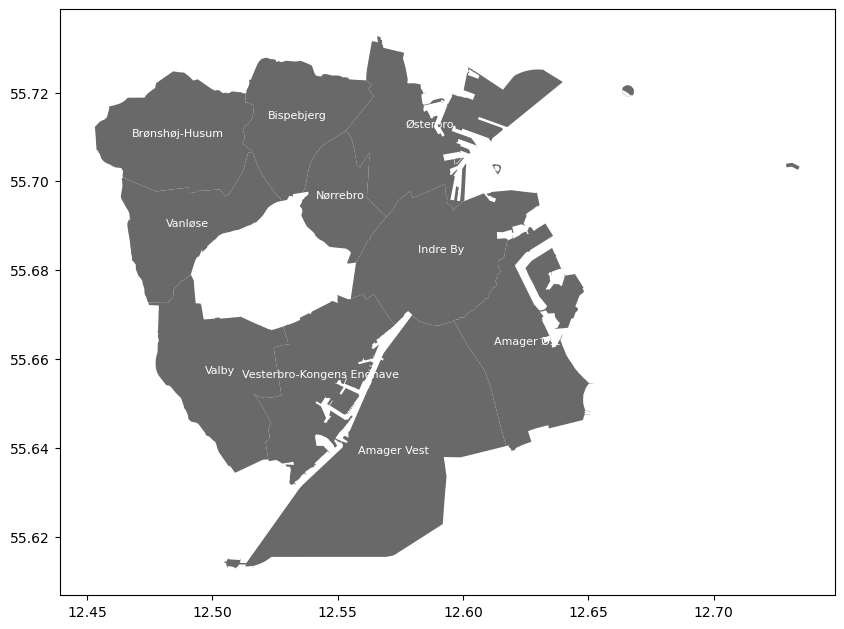

In [17]:
# Read data
districts = gpd.read_file('Data/bydel.json')

# Set the figure size and plot
fig, ax = plt.subplots(figsize=(10, 10))  
districts.plot(ax=ax, color = 'dimgray')

# Add labels to the plot
for idx, row in districts.iterrows():
    plt.annotate(text=row['navn'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), ha='center', fontsize=8, color = 'white')

plt.show()

<a id="basic7"></a> <br>
### Bicycle lanes, parks, trees

We have also imported data related to bicycle lanes, street trees and parks/green areas. The data sets are available on Open Data DK here:
* [Bicycle lane data](https://www.opendata.dk/city-of-copenhagen/cykeldata)
* [Park data](https://www.opendata.dk/city-of-copenhagen/gronne-omrader#resource-gronne-omrader.geojson)
* [Street tree data](https://www.opendata.dk/city-of-copenhagen/gadetraeer)

These data sets are mainly for making nice maps. So we want go into details here.

In [18]:
import geopandas as gpd
trees = gpd.read_file('Data/gadetraer.json')
print('Dimension of data set: \t', trees.shape)
print('\nFeatures: \t',  set(trees.columns))

Dimension of data set: 	 (20132, 28)

Features: 	 {'driftsplan_navn', 'id', 'slaegtsnavn', 'slaegt', 'bydelsnavn', 'ejer', 'dansk_navn', 'fredning_edoc_nr', 'andre_vaekstforhold', 'vejstatus', 'driftsorganisation', 'fredet_trae_foto', 'ogc_fid', 'trae_historie', 'saerligt_trae', 'saerlig_trae_bem', 'plantet_halvaar', 'geometry', 'garantiperioden_udloeber', 'planteaar', 'bemaerkning', 'botanisk_interesse', 'fredet_beskyttet_trae', 'driftsaftale_edoc_nr', 'plantemetode', 'traeart', 'donor', 'anledning'}


In [19]:
parks = gpd.read_file('Data/park_groent_omr_oversigtskort.json')
print('Dimension of data set: \t', parks.shape)
print('\nFeatures: \t',  set(parks.columns))

Dimension of data set: 	 (300, 5)

Features: 	 {'kommune', 'objekt_type', 'geometry', 'id', 'ogc_fid'}


In [20]:
bike_data = gpd.read_file('Data/cykeldata_kk.json')
print('Dimension of data set: \t', bike_data.shape)
print('\nFeatures: \t', set(bike_data.columns))
print('\nCategories: \t', set(bike_data['kategori']))

Dimension of data set: 	 (3384, 9)

Features: 	 {'kommune', 'kategori', 'geometry', 'rute_nr', 'id', 'ogc_fid', 'under_kategori', 'status', 'rutenavn'}

Categories: 	 {'Supercykelsti', 'Cykelmulighed', 'Grøn', 'Cykelsti'}


<a id="ana"></a> <br>
# Data Analysis

____

<a id="ana1"></a> <br>
### How is the distribution of road users in Copenhagen?

Copenhagen is known for the many bicyclers. It this section of the data analysis, we wish to investigate the traffic count data to see if Copenhagen lives up to their reputation as a bicycle metropolis. 

First lets count how many of the count locations have more bikes than cars:

In [21]:
subset_types = subset_types.replace(0, np.nan)

# Count bike-dominated spots
subset_types['more_bikes'] = (subset_types['aadt_koretojer'] < subset_types['aadt_cykler'])

print('Counting spots in total: \t', len(subset_types['more_bikes']))
print('Counting spots with most bikes: ', sum(subset_types['more_bikes']!=False))

Counting spots in total: 	 296
Counting spots with most bikes:  44


Interesting! Only around 15% of the spots have a majority of bikes. Lets plot the data on a map to see how the traffic distribution is across the districts of Copenhagen:

In [22]:
scale = 0.0006
subset_types = subset_types.replace(np.nan, 0)



# Create trace for cars
cars = go.Scattermapbox(
    lat = subset_types['X'],
    lon = subset_types['Y'],
    mode='markers',
    marker=dict(
        size=subset_types['aadt_koretojer'] * scale,
        color=colors[1],
        opacity=0.7
    ),
    text= subset_types['aadt_koretojer'], 
    textposition='top center', 
    name='Vehicles',
    hoverinfo='text'
)

# Create trace for bikes
bikes = go.Scattermapbox(
    lat = subset_types['X'],
    lon = subset_types['Y'],
    mode='markers',
    marker=dict(
        size=subset_types['aadt_cykler'] * scale,
        color=colors[2],
        opacity=0.7
    ),
    text= subset_types['aadt_cykler'],  
    textposition='top center', 
    name='Bikes', 
    hoverinfo='text', visible=True
)

# Create trace for predestrians
pedestrians = go.Scattermapbox(
    
    lat = subset_types['X'],
    lon = subset_types['Y'],
    mode='markers',
    marker=dict(
        size=subset_types['aadt_fod_7_19'] * scale, 
        color=colors[4],
        opacity=0.7
    ),
    text= subset_types['aadt_fod_7_19'],  #
    textposition='top center', 
    name='Pedestrians', hoverinfo='text', visible=True
)

# Create trace for bike-dominated spots
most_bikes = go.Scattermapbox(
    lat = subset_types[subset_types['more_bikes'] == True]['X'],
    lon = subset_types[subset_types['more_bikes'] == True]['Y'],
    mode='markers',
    marker=dict(
        size=5, 
        color='black',
        opacity=1,
        symbol='circle'
    ),
    text= 'Bike-dominated',  
    textposition='top center', 
    name='Bike-dominated', hoverinfo='text', visible=False
)

# Create trace for car-dominated spots
most_cars = go.Scattermapbox(
    lat = subset_types[subset_types['more_bikes'] == False]['X'],
    lon = subset_types[subset_types['more_bikes'] == False]['Y'],
    mode='markers',
    marker=dict(
        size=5, 
        color='black',
        opacity=1,
        symbol='circle'
    ),
    text= 'Car-dominated', 
    textposition='top center', 
    name='Car-dominated', hoverinfo='text', visible=False
)

# Create district trace
district_trace = go.Choroplethmapbox(
    geojson=districts.__geo_interface__, 
    locations=districts.index, 
    z=[1]*len(districts), # Set the z value to a constant value of 1 for all districts
    colorscale=[[0, 'gray'], [1, 'gray']], # Set the colorscale to a single color 
    showscale=False, # Hide the colorbar
    colorbar=dict(title='navn'), 
    hoverinfo='text', # Show district name on hover
    text=districts['navn'],marker=dict(opacity=0.1) 
)

# Create a list of traces
traces = [cars, bikes, pedestrians, most_bikes, most_cars, district_trace]

# Create the layout of the map with buttons
layout = go.Layout(
    height=550,
    width=1000,
    mapbox_style="carto-positron",
    mapbox_zoom=11,
    mapbox_center = {"lat": 55.6761, "lon": 12.5683},
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [{"visible": [True, True, True, False, False, True]}],
                    "label": "All",
                    "method": "update"
                },                  
                {
                    "args": [{"visible": [True, False, False, False, False, True]}],
                    "label": "Vehicles",
                    "method": "update"
                },
                {
                    "args": [{"visible": [False, True, False, False, False, True]}],
                    "label": "Bikes",
                    "method": "update"
                },
                {
                    "args": [{"visible": [False, False, True, False, False, True]}],
                    "label": "Pedestrians",
                    "method": "update"
                },
                {
                    "args": [{"visible": [False, False, False, True, False, True]}],
                    "label": "Bike-dominated",
                    "method": "update"
                },
                {
                    "args": [{"visible": [False, False, False, False, True, True]}],
                    "label": "Car-dominated",
                    "method": "update"
                }                   
            ],
            "direction": "down",
            "showactive": True,
            "type": "buttons",
            "x": 1,
            "y": 1
        }
    ]
)

# Create the figure
fig = go.Figure(data=traces, layout=layout)


# Set the margin size
margin_size = 0  # Adjust this value as needed

# Update the layout with the desired margin
fig.update_layout(margin=dict(t=margin_size, b=margin_size, l=margin_size, r=margin_size))


# Save the figure as an HTML file
#plot(fig, filename='count.html', auto_open=False)

# Show the figure
fig.show()

From the above map, it can be seen, that only the city center and Nørrebro have many bike-dominated spots. The rest of the districts have three or less bike-dominated spots. It can also be seen from the plot that there are a lot of vehicles counted at the roads going in to the Copenhagen Area from the suburbs and at Åboulevarden and H.C. Andersens Boulevard.

Moreover, it seems like they did not count pedestrians outside the city center. 

<a id="ana_ty"></a> <br>
### How is the distribution of car types according to district?

Lets investigate the distribution of car types in the districts of Copenhagen. From the plot below, we can conclude that the districts are very similar according to the distribution of car types. Moreover, petrol cars are dominating.

In [23]:
fig = go.Figure()
i = 0

for car_type_df in [car_types_oevrige, car_types_El, car_types_Benzin, car_types_Diesel ,car_types_Hybrid]:
    car_type = car_types[i] 
    number_area = 0
    for area in areas:
        listi = []
        area_data = car_type_df[car_type_df.iloc[:, 0] == area].iloc[:, 1:].values[0]
        for moins in range(len(area_data)): 
            if float(area_sum[names_year[moins]][number_area]) == 0:
                listi.append(0)
            else:
                a = float(area_data[moins])/float(area_sum[names_year[moins]][number_area])
                area_data[moins] =  a
                listi.append(a)
        if number_area == 0:
            fig.add_trace(go.Scatter(x=car_type_df.columns[1:], y=listi, name=f"{car_type} - {area}",visible = True,fill='tonextx' ,stackgroup='group'))
        else:
            fig.add_trace(go.Scatter(x=car_type_df.columns[1:], y=listi, name=f"{car_type} - {area}",visible = False,fill='tonextx' ,stackgroup='group'))
        number_area += 1
    i += 1
    
fig.update_layout(
    updatemenus=[
        dict(
            type="dropdown",
            buttons=[
                dict(label=area, method="update", args=[{"visible": [trace.name.endswith(area) for trace in fig.data], "title": area}])
                for area in areas
            ],
            direction="down",
            showactive=True,
            x=0.55,
            y=1.1
        )   
    ]
)

fig.update_layout(
    title="Car Type",
    xaxis_title="Year",
    yaxis_title="Proportion"
)

# Save the figure as an HTML file
#plot(fig, filename='cartypes_2.html', auto_open=False)
fig.show()

<a id="ana2"></a> <br>
### How safe is the traffic in Copenhagen? 

In this section, we investigate traffic accidents in Copenhagen. The plot below explores the traffic accidents for three categories: Killed, Serious injuries and Minor injuries. The plot also contains information about the transportation form of the victim.

In [24]:
# create the traces for each group
trace1 = go.Scatter(x=accidents['Year'], y=accidents['Killed - Passenger cars'], name='Passenger cars', visible=True)
trace2 = go.Scatter(x=accidents['Year'], y=accidents['Killed - Cyclists'], name='Cyclists', visible=True)
trace3 = go.Scatter(x=accidents['Year'], y=accidents['Killed - Pedestrians'], name='Pedestrians', visible=True)
trace4 = go.Scatter(x=accidents['Year'], y=accidents['Serious injuries - Passenger cars'], name='Passenger cars', visible=False)
trace5 = go.Scatter(x=accidents['Year'], y=accidents['Serious injuries - Cyclists'], name='Cyclists', visible=False)
trace6 = go.Scatter(x=accidents['Year'], y=accidents['Serious injuries - Pedestrians'], name='Pedestrians', visible=False)
trace7 = go.Scatter(x=accidents['Year'], y=accidents['Minor injuries - Passenger cars'], name='Passenger cars', visible=False)
trace8 = go.Scatter(x=accidents['Year'], y=accidents['Minor injuries - Cyclists'], name='Cyclists', visible=False)
trace9 = go.Scatter(x=accidents['Year'], y=accidents['Minor injuries - Pedestrians'], name='Pedestrians', visible=False)


# create the toggle button
button_layer_1 = dict(label='Killed',
                      method='update',
                      args=[{'visible': [True, True, True, False, False, False, False, False, False]},
                            {'title': 'Traffic Accidents i Copenhagen - Killed '}])
button_layer_2 = dict(label='Serious injuries',
                      method='update',
                      args=[{'visible': [False, False, False,True, True, True, False, False, False]},
                            {'title': 'Traffic Accidents i Copenhagen - Serious injuries'}])
button_layer_3 = dict(label='Minor injuries',
                      method='update',
                      args=[{'visible':  [False, False, False, False, False, True, True, True, False]},
                            {'title': 'Traffic Accidents i Copenhagen - Minor injuries'}])
buttons = [button_layer_1, button_layer_2, button_layer_3]

# create the layout
layout = go.Layout(title='Traffic Accidents i Copenhagen ',
                   xaxis=dict(title='Year'),
                   yaxis=dict(title='Count'),
                   updatemenus=[dict(type='buttons',
                                     showactive=True,
                                     x = 1, 
                                     y = 1,
                                     buttons=buttons)])

# create the figure and add the traces and layout
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9], layout=layout)



# Set the margin size
margin_size = 10  # Adjust this value as needed


# Save the figure as an HTML file
#plot(fig, filename='accidents.html', auto_open=False)

# show the figure
fig.show()


From the traffic accidents plot, we found out that luckily only few people die every year in traffic accidents in Copenhagen. There are actually more people dying from traffic related air pollution in Copenhagen. It is estimated that air pollution is responsible for an estimated 550 premature deaths in Copenhagen each year. Lets investigate the air pollution data. The data is plotted below for to locations in Copenhagen a long with the legal binding pollutants limit set by the EU. For all three pollutants the level have dropped over the years and Copenhagen has reached an acceptable amount for NO2 and SO2, but are still not below the limit for NOx.

In [25]:
# create the traces for each group
trace1 = go.Scatter(x=loc_1103['year'], y=np.log(loc_1103['NO2']), name='NO2', fillcolor=colors[0], visible=True)
trace2 = go.Scatter(x=loc_1103['year'], y=np.log(loc_1103['NOx']), name='NOx', fillcolor=colors[1], visible=True)
#trace3 = go.Scatter(x=loc_1103['year'], y=np.log(loc_1103['PM10']), name='PM10', fillcolor=colors[2], visible=True)
trace4 = go.Scatter(x=loc_1103['year'], y=np.log(loc_1103['SO2']), name='SO2', fillcolor=colors[2], visible=True)
trace5 = go.Scatter(x=loc_1257['year'], y=np.log(loc_1257['NO2']), name='NO2', fillcolor=colors[0], visible=False)
trace6 = go.Scatter(x=loc_1257['year'], y=np.log(loc_1257['NOx']), name='NOx', fillcolor=colors[1], visible=False)
#trace7 = go.Scatter(x=loc_1257['year'], y=np.log(loc_1257['PM10']), name='PM10', fillcolor=colors[2], visible=False)
trace8 = go.Scatter(x=loc_1257['year'], y=np.log(loc_1257['SO2']), name='SO2', fillcolor=colors[2], visible=False)

# create the toggle button
button_layer_1 = dict(label='H.C. Andersens Boulevard',
                      method='update',
                      args=[{'visible': [True, True, True, False, False, False]},
                            {'title': 'Pollution in Copenhagen in log scale'}])
button_layer_2 = dict(label='Jagtvej',
                      method='update',
                      args=[{'visible': [False, False, False,True, True, True]},
                            {'title': 'Pollution in Copenhagen in log scale'}])

buttons = [button_layer_1, button_layer_2]

# create the layout
layout = go.Layout(title='Pollution in Copenhagen in log scale',
                   xaxis=dict(title='Year'),
                   yaxis=dict(title='Count'),
                   updatemenus=[dict(type='buttons', 
                                     showactive=True,
                                     x = 0.23, 
                                     y = 1,
                                     buttons=buttons)],
        shapes=[dict(type='line', y0=np.log(40), y1=np.log(40), x0=2010, x1=loc_1103['year'].max(),line=dict(color=colors[0], width=1, dash='dot')),
                dict(type='line', y0=np.log(30), y1=np.log(30), x0=2010, x1=loc_1103['year'].max(),line=dict(color=colors[1], width=1, dash='dot')),
                dict(type='line', y0=np.log(20), y1=np.log(20), x0=2010, x1=loc_1103['year'].max(),line=dict(color=colors[2], width=1, dash='dot'))]
)

# create the figure and add the traces and layout
fig = go.Figure(data=[trace1, trace2, trace4, trace5, trace6, trace8], layout=layout)

# show the figure
fig.show()

In [26]:
# Save the figure as an HTML file
#plot(fig, filename='pollution.html', auto_open=False)#

<a id="ana3"></a> <br>
### How to plan a safe and green bike trip?

After investigation the safety and pollution in the streets of Copenhagen, it is obvious to ask "*How do I plan a safer trip in Copenhagen*". In Copenhagen there exist super bicycle lanes and green bicycle lanes. These lanes have focus on comfort and safety. The map below shows these special bicycle lanes along with parks and trees, making it possible to plan a safe and green trip.

In [27]:
# Select subset of data
green_bike_data = bike_data[(bike_data['kategori'] == 'Grøn') | (bike_data['kategori'] == 'Supercykelsti')]

# Create a new trace for the parks 
park_trace = go.Choroplethmapbox(
    geojson=parks.geometry.__geo_interface__,
    locations=parks.index, 
    colorscale=[[0, 'lightgreen'], [1, 'lightgreen']], 
    z=np.ones(len(parks['ogc_fid'])), 
    colorbar=dict(title='ogc_fid'), 
    marker=dict(opacity=0.5), 
    hoverinfo='text',
    showscale=False,
    text=parks['objekt_type'],
    name='Parks' 
)

tre = go.Scattermapbox(
    lat =trees['geometry'].y,
    lon = trees['geometry'].x,
    mode='markers',
    marker=dict(
        size=3, 
        color='forestgreen',
        opacity=1,
        symbol='circle'
    ),
    text= trees['traeart'],  
    textposition='top center', 
    name='Trees', hoverinfo='text'
)

# Create a new trace for the bike lanes using Scattermapbox
road_traces = []
for geometry in green_bike_data['geometry']:
    if isinstance(geometry, LineString):
        # If the geometry is a LineString, create a new trace for it
        road_trace = go.Scattermapbox(
            lat=[geometry.xy[1][i] for i in range(len(geometry.xy[0]))], 
            lon=[geometry.xy[0][i] for i in range(len(geometry.xy[0]))],
            mode='lines',
            line=dict(
                color='lime4', 
                width=2 
            ),
            hoverinfo='none' 
        )
        road_traces.append(road_trace)
    elif isinstance(geometry, MultiLineString):
        # If the geometry is a MultiLineString, loop over each LineString and create a new trace for each one
        for line in geometry.geoms:
            road_trace = go.Scattermapbox(
                lat=[line.xy[1][i] for i in range(len(line.xy[0]))], 
                lon=[line.xy[0][i] for i in range(len(line.xy[0]))], 
                mode='lines',
                line=dict(
                    color='limegreen', 
                    width=2 
                ),
                showlegend=False,  
                hoverinfo='none' 
            )
            road_traces.append(road_trace)

# Create a new layout for the map
layout = go.Layout(
    height=550,
    width=750,
    mapbox=dict(
        style = 'carto-positron',
        zoom=10, 
        center=dict(lat=55.6761, lon=12.5683) 
    ),
    showlegend=True 
)

# Create a new figure with all the trace objects
fig = go.Figure()
fig.add_trace(park_trace)
#fig.add_trace(legend_trace)
#fig.add_trace(tre)
fig.update_layout(layout)
fig.update_layout(mapbox=dict(style='carto-positron', zoom=10, center=dict(lat=55.6761, lon=12.5683)))

# Add each road trace object
for road_trace in road_traces:
    fig.add_trace(road_trace)

# Set the margin size
margin_size = 0  # Adjust this value as needed

# Update the layout with the desired margin
fig.update_layout(margin=dict(t=margin_size, b=margin_size, l=margin_size, r=margin_size))

#fig.show(config={'displayModeBar': True, 'scrollZoom': True, 'responsive': True, 'displaylogo': False, 'modeBarButtonsToAdd': ['zoomIn2d', 'zoomOut2d', 'autoScale2d', 'resetScale2d', 'hoverClosestCartesian', 'hoverCompareCartesian', 'toggleSpikelines', 'fullscreen']})
fig.show()

In [28]:
# Save the figure as an HTML file
# plot(fig, filename='greenmap.html', auto_open=False)

<a id="genre"></a> <br>
# Genre


In this section, we will go through the thoughts behind our visual narrative and structure and relate it to the article from Segal and Heer from 2010. The most important tools related to the visual narrative is the consistency of the platform. Our goal is to tell a story that enlighten many aspects of the traffic patterns in Copenhagen. This means that, we have both map plots, area charts and time series plots. To maintain a consistent visual narrative, we have using Plotly as the platform for all plot types, employing the same layout. This approach aims to prevent confusion among our users. More over, the maps allow the users to zoom for highlighting of specific areas.

When it comes to visual structure, we have used many different tools. The ordering of the structure is a mix of a linear author-driven structure and user directed path allowing us to guide the users in how to engage with out interactive plots. We have used a lot of tools for interactivity. Considering that traffic in Copenhagen may be perceived as a less engaging topic, we have implemented interactive features such as zooming and neighborhood-specific information to enhance user engagement. The interactive tools we have incorporated include hover highlighting for plot and map details, filtering options based on for instance districts and traffic type, as well as navigation buttons for map exploration.

To provide context and relevance to the data, we have complemented the visual plots with an accompanying article. This approach ensures that the data is presented within the appropriate context, including relevant laws, political decisions and background knowledge. We also make use of multi-messaging, where both the articles and the plots communicates the messages making it more fun for the user.

<a id="viz"></a> <br>
# Visualization



The story we wish to tell, was not outlined in specifics, but rather a combination of different facts in order to get the most out of the Copenhagen data. More of this will be mentioned in the discussion. 


The choice of our visualizations is based on, that we were surprised by the fact, that the cars are dominating most of the city, despite Copenhagen being known as a bicycle metropolis. This led to us wanting to dick up other dirty secrets, like the noise level and other negative consequences the car traffic has. The harmful emissions and traffic accidents plots suits this idea perfectly, adding some dramatic effect to our story.

Now the plots will be explained individually.

The first plot, the traffic count map, was chosen for obvious reasons, as we wish to tell the reader, that despite Copenhagen being a bicycle metropolis, there are still a lot of cars.

The next plot, the car types plot, was chosen specifically to underline, that very few cars are electric, as this is natural question one could ask, as Denmark is a country is known for sustainability. The grouping in areas provides a more detailed understanding and also encourages the reader to explore the map further. 

Next up, the emission plot was an obvious choice, when investigating traffic. Here the EU-guidelines are necessary to put the values into context. 

The traffic accidents plot was chosen specifically to highlight one of the negative consequences of car traffic in cities. 

The bicycle lane map was chosen to leave the reader with a positive emotion in the end of the story after hearing about all the negative consequences of car traffic in urban areas. This plot should also motivate people to use there bikes instead of cars, by making it easier to find a nice route. 

<a id="dis"></a> <br>
# Discussion




First of, we faced a great challenge in the data set, we chose. Copenhagen is famous for its biking culture and we absolutely wanted to go with this city. But the data quality was not good, no matter which site, we visited. An unusual amount of time was used on finding data set, which we could build our analysis on. We found most of our data at Statistikbanken and Opendata DK. 
Our findings resulted in a lot of separate data set, that are difficult to merge, therefore the analysis became a bit separate. Also a lot of different data set were invested, before discarding. Furthermore the data set are quite small, larger data set are necessary for a deeper analysis. Most disappointing was, that we wanted to link the traffic according to how noisy the roads are, but the noise data did only contain data for making noise calculations and not the actual noise data.

Now, not only the finding of suitable data sets, did not go as well as hoped, but the data set we ended up using, was quite challenging. Especially the data sets from Statistikbanken are not given in a format, where you can use the data immediately, so a lot of data cleaning was necessary, before being able to load it in python. A districts-wise analysis would be of more useful for urban planners, which we didn't manage due to the lack of data sets containing district wise information, but is definitely something worth investigating more. 

With regards to the plots, the car type plot it is not as illustrative as hoped, as the amount of the other types but petrol and diesel is almost too small to see visually. Moreover, the districts were very similar.

Finally our Basic stat section seems a little unstructured due to the amount of data sets used. It is safe to say, though, that there isn't a single dataset left, that we haven't investigated with regards to copenhagen traffic.

All of this resulted in difficulties keeping a red thread through our analysis, which we managed to do despite. The red thread is formed in an emotional guide through the discovery of a lot of different facts about Copenhagen. Starting of, we set Copenhagen in a positive light, before we moving on to the discovery of large parts of the city are dominated by cars, which is a bit more negative, seen from a environmental point of view.  This negative emotion is further emphasized, when we bring up the amount of people killed and the air pollution. 

Finally, we leave the reader with a positive experience, when guiding them towards a nice bicycle trip. 

The interactive plots is another aspect that went well, leaving some room for the reader to go on discovery. We wanted to used folium plots, but it took to long long larger amounts of data to the website, so we went with plotly. 

Due to this and our well formulated text, we managed to make a rather boring subject more exciting. 

If we had more time, we would want to improve the analysis by including even more data set and improve the visualizations further e.g. by including gender or age range. 
A layout of the website with a moving bicycle when scrolling would have been the cherry on top of the ice cream. We tried doing this, but failed. 





<a id="cont"></a> <br>
# Contributions

For the the sections **basics stats** and **data analysis** in the Jupiter notebook along with the **web site text** the contributions are divided based on data sets:

|Topic/data | Emilie | Esther |
| --- | --- | --- |
| Traffic count data | X |   |
| Traffic accidents data | X | X |
| Car types data |   | X |
| Air pollution data | X  |
| Park, trees, bicycle lanes| X |  |

For the rest of the Jupiter Notebook

|Topic/data | Emilie | Esther |
| --- | --- | --- |
| Motivation| X |   |
| Genre | X |  |
| Discussion |   | X |
| Visualizations |    | X |

